### list of ft models
- 'ada:ft-personal-2023-03-13-22-18-36'
  - 3 class, initial attempt
- "ada:ft-personal-2023-03-17-16-36-40"
  - also 3 class, but I regarded this one as better
- "ada:ft-personal-2023-03-17-17-21-10"
  - labels with spaces removed
- "ada:ft-personal-2023-03-17-17-49-37"
  - data shuffled now
- "curie:ft-personal-2023-03-17-18-08-07"
  - trained on curie to see of results better
- "ada:ft-personal-2023-03-20-00-09-00"
  - went up to 10 epochs and back to ada

In [11]:
ft_model = "ada:ft-personal-2023-03-20-00-09-00"

In [12]:
import pandas as pd
import openai
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [13]:

api_key = os.getenv("OPENAI_API_KEY")
print(type(api_key))
openai.api_key = api_key

data = pd.read_excel("data.xlsx")

labels = data['student'] 
texts = data['response']

df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

df.to_excel("3class.xlsx")

df.to_json("essays.jsonl", orient='records', lines=True)

# !openai tools fine_tunes.prepare_data -f essays.jsonl -q

# !openai api fine_tunes.create -t "essays_prepared_train.jsonl" -v "essays_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " 10th grade" -m ada

# !openai api fine_tunes.results -i ft-B29wadYuk9CqMvVvKJKQ4P5u > student_result5.csv

<class 'str'>


      step  elapsed_tokens  elapsed_examples  training_loss  \
241    242          204202               242       0.013621   
482    483          407475               483       0.014840   
723    724          610924               724       0.013891   
963    964          813732               964       0.009336   
1204  1205         1016733              1205       0.011254   
1445  1446         1219886              1446       0.005043   
1685  1686         1422782              1686       0.008283   
1925  1926         1625518              1926       0.005550   
2166  2167         1828711              2167       0.006437   
2400  2401         2026521              2401       0.008004   

      training_sequence_accuracy  training_token_accuracy  validation_loss  \
241                          0.0                 0.666667              NaN   
482                          0.0                 0.000000              NaN   
723                          1.0                 1.000000              N

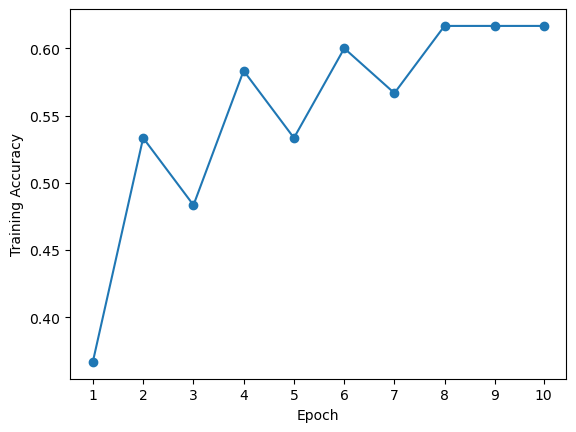

In [33]:
results = pd.read_csv('student_result5.csv')
results_filtered = results[results['classification/accuracy'].notnull()].tail(10)


print(results_filtered)

print(results_filtered[results_filtered['classification/accuracy'].notnull()].tail(1))

results_filtered[results_filtered['classification/accuracy'].notnull()]['classification/accuracy'].plot(marker='o')

# Add x and y axis labels
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.xticks(ticks = [241, 482, 723, 963, 1204, 1445, 1685, 1925, 2166, 2400],labels= range(1, 11))
plt.show()

Text(0, 0.5, 'Training Loss')

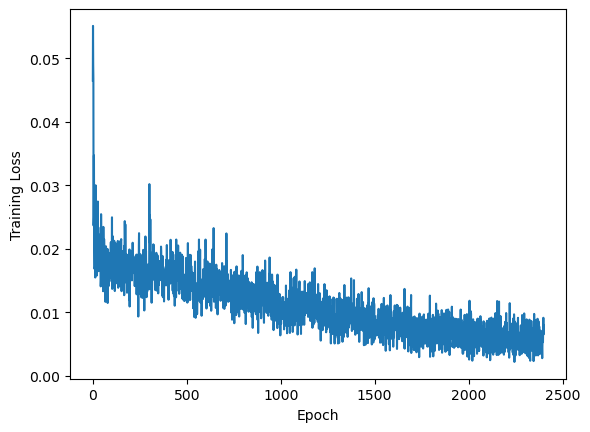

In [15]:
results[results['training_loss'].notnull()]['training_loss'].plot()

plt.xlabel('Epoch')
plt.ylabel('Training Loss')

In [16]:
test = pd.read_json('students2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,\n\nThanksgiving is the day when families get ...,6thgrade
1,\n\nHave you ever heard of early jets? They we...,6thgrade
2,\n\nSilicon Valley is a term used to describe ...,10thgrade
3,\n\nCivic humanism is a philosophy that emphas...,6thgrade
4,\n\nBoomer-Lit And The Silver Economy\n\nBoome...,6thgrade


In [17]:
for i in range(len(test)):
    res = openai.Completion.create(model=ft_model, prompt=test['prompt'][i] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
    test.loc[i, 'prediction'] = res['choices'][0]['text']
    #test.loc[i, 'log_probs'] = res['choices'][0]['logprobs']['top_logprobs'][0]

print(test.head(20))

                                               prompt  completion prediction
0   \n\nThanksgiving is the day when families get ...    6thgrade          6
1   \n\nHave you ever heard of early jets? They we...    6thgrade          6
2   \n\nSilicon Valley is a term used to describe ...   10thgrade    college
3   \n\nCivic humanism is a philosophy that emphas...    6thgrade         10
4   \n\nBoomer-Lit And The Silver Economy\n\nBoome...    6thgrade          6
5   \n\nNormandy Seventy Five Years On\n\nThe Norm...    6thgrade          6
6   \n\nDonating to a good cause is a noble act th...   10thgrade          6
7   \n\nIn the Yoruba tribe of West Africa, the bi...     college         10
8   \n\nAs the 2019–2020 NBA season draws to a clo...     college         10
9   \n\nThe USHJA Wheeler Museum is a historically...   10thgrade         10
10  \n\nEvelyn McHale’s Most Beautiful Suicide\n\n...   10thgrade         10
11  \n\nThe end of World War II marked a turning p...     college    college

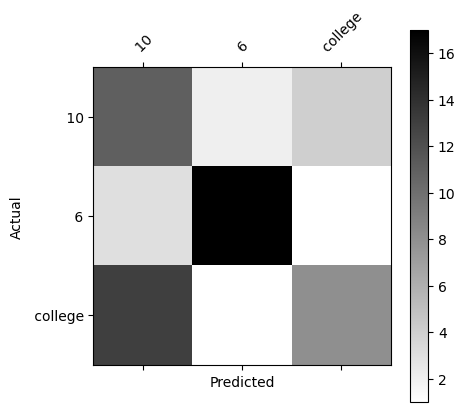

In [18]:
classes = list(test['prediction'].unique())

test['completion'] = test['completion'].str.replace('thgrade', '')

y_actu = pd.Series(test['completion'].values, name='Actual')
y_pred = pd.Series(test['prediction'].values, name='Predicted')

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


df_confusion = pd.crosstab(y_actu, y_pred)
plot_confusion_matrix(df_confusion)

In [19]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(df_confusion, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    fmt = 'd'
    thresh = df_confusion.values.max() / 2.
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        plt.text(j, i, format(df_confusion.values[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if df_confusion.values[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


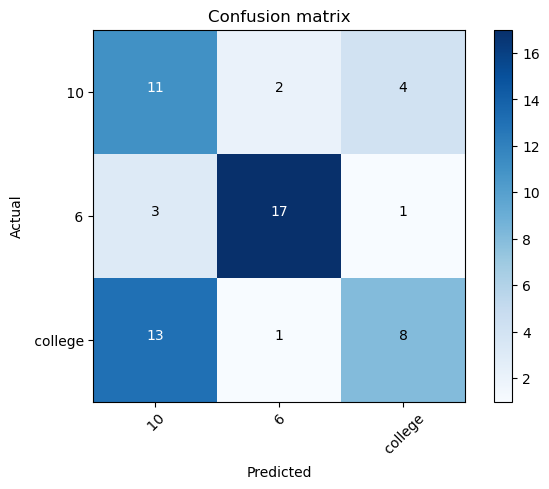

In [21]:
import itertools

classes = list(test['prediction'].unique())

test['completion'] = test['completion'].str.replace('thgrade', '')

y_actu = pd.Series(test['completion'].values, name='Actual')
y_pred = pd.Series(test['prediction'].values, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred)
plot_confusion_matrix(df_confusion)